In [7]:
import numpy as np
import os
import tensorflow as tf
import keras
import cv2
import matplotlib.pyplot as plt
import scipy.io
from tqdm import tqdm
import time 
from PIL import Image 

In [8]:
data_dir = "C:/Users/JanRottmayer/Documents/Python Scripts/Cars"
path = "C:/Users/JanRottmayer/Documents/Python Scripts/Cars/cars_train/cars_train/"

In [9]:
# initialize min/max
min_w=1000
max_w=0
min_h=1000
max_h=0
width_array=[]
height_array=[]
for img in os.listdir(path):
    img = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
    if img.shape[0]>max_w:
        max_w = img.shape[0]
    if img.shape[0]<min_w:
        min_w = img.shape[0]
    if img.shape[1]>max_h:
        max_h = img.shape[0]
    if img.shape[1]<min_h:
        min_h = img.shape[0]
    width_array.append(img.shape[0])
    height_array.append(img.shape[1])
print(min_h,min_w)

58 57


In [22]:
train_dir = "C:/Users/JanRottmayer/Documents/Python Scripts/Cars/cars_train/cars_train/"
test_dir = "C:/Users/JanRottmayer/Documents/Python Scripts/Cars/cars_test/cars_test/"
label_path = "C:/Users/JanRottmayer/Documents/Python Scripts/Cars/cars_annos.mat"
IMG_SIZE = 58

def create_training_data(path,WIDTH=IMG_SIZE, HEIGHT=IMG_SIZE):
    training_data = []
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array,(WIDTH,HEIGHT))
            training_data.append(np.uint8(new_array))
        except:
            pass
    return np.array(training_data)

def read_label(label_path):
    mat = scipy.io.loadmat(label_path)
    mat = mat["annotations"]
    labels = []
    annotations = np.transpose(mat)
    for annotation in annotations: 
        labels.append(annotation[0][5][0][0])
    return labels

In [20]:
test = create_training_data(train_dir,IMG_SIZE,IMG_SIZE)

In [23]:
x_train = create_training_data(train_dir,IMG_SIZE,IMG_SIZE)
x_test = create_training_data(test_dir,IMG_SIZE,IMG_SIZE)
labels = read_label(label_path)
train_data = np.concatenate((x_train,x_test),axis=0)

(8144, 58, 58, 3)

In [30]:
# hyper parameters 
batch_size = 512
epochs = 20
sample_size = 64
nz = 128 # latent vector size
channels = 3

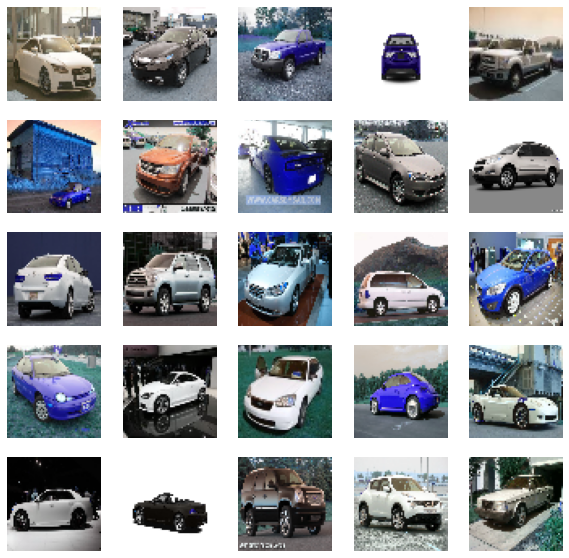

In [33]:
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_data[i])
    plt.axis('off')
plt.show()

In [130]:
# Generator using Dense Layers
def create_generator():
    gen_input = keras.Input(shape=(nz,))
    x = keras.layers.Dense(256)(gen_input)
    x = keras.layers.LeakyReLU()(x)

    x = keras.layers.Dense(512)(x)
    x = keras.layers.LeakyReLU()(x)

    x = keras.layers.Dense(1024)(x)
    x = keras.layers.LeakyReLU()(x)

    x = keras.layers.Dense(2056)(x)
    x = keras.layers.LeakyReLU()(x)

    x = keras.layers.Dense(5112)(x)
    x = keras.layers.LeakyReLU()(x)
    
    x = keras.layers.Dense(10092)(x)
    x = keras.layers.LeakyReLU()(x)
    
    x = keras.layers.Reshape((58,58,3,), input_shape=(10092,))(x)
    x = keras.layers.Activation('sigmoid')(x)
    
    generator = keras.Model(gen_input, x)
    return generator

In [131]:
# Generator using only Flat input/output, output shape (10092,)
def create_generator_vgan():
    gen_input = keras.Input(shape=(nz,))
    x = keras.layers.Dense(256)(gen_input)
    x = keras.layers.LeakyReLU()(x)

    x = keras.layers.Dense(512)(x)
    x = keras.layers.LeakyReLU()(x)

    x = keras.layers.Dense(1024)(x)
    x = keras.layers.LeakyReLU()(x)

    x = keras.layers.Dense(2056)(x)
    x = keras.layers.LeakyReLU()(x)

    x = keras.layers.Dense(5112)(x)
    x = keras.layers.LeakyReLU()(x)
    
    x = keras.layers.Dense(10092)(x)
    x = keras.layers.Activation('sigmoid')(x)
        
    generator = keras.Model(gen_input, x)
    return generator

In [132]:
# Generator using Deconvolution Layers
def create_generator_dcgan():
    gen_input = keras.Input(shape=(nz,))
    x = keras.layers.Dense(256*16*16)(gen_input)
    x = keras.layers.LeakyReLU()(x)

    x = keras.layers.Reshape((16, 16, 256))(x)
    
    x = keras.layers.Conv2D(256, 3, padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    
    x = keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    
    x = keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    
    x = keras.layers.Conv2D(512, 3, padding='valid')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2D(512, 3, padding='valid')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2D(channels, 3, activation='sigmoid', padding='valid')(x)
    
    generator = keras.Model(gen_input, x)
    return generator

In [133]:
def create_discriminator():
    disc_input = keras.Input(shape=(IMG_SIZE,IMG_SIZE,channels))
    
    x = keras.layers.Conv2D(256, 3)(disc_input)
    x = keras.layers.LeakyReLU()(x)
    
    x = keras.layers.Conv2D(256, 4, strides=2)(x)
    x = keras.layers.LeakyReLU()(x)
    
    x = keras.layers.Conv2D(256, 4, strides=2)(x)
    x = keras.layers.LeakyReLU()(x)
    
    x = keras.layers.Conv2D(256, 4, strides=2)(x)
    x = keras.layers.LeakyReLU()(x)
    
    x = keras.layers.Conv2D(256, 4, strides=2)(x)
    x = keras.layers.LeakyReLU()(x)
    
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.Dense(1, activation = 'sigmoid')(x)
    discriminator = keras.Model(disc_input, x)
    
    optimizer = tf.keras.optimizers.RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
    discriminator.compile(optimizer=optimizer, loss='binary_crossentropy'
    )
    return discriminator

In [138]:
def create_discriminator_vgan():
    disc_input = keras.Input(shape=(IMG_SIZE*IMG_SIZE*channels))
    
    x = keras.layers.Dense(10092)(disc_input)
    x = keras.layers.LeakyReLU()(x)

    x = keras.layers.Dense(5112)(x)
    x = keras.layers.LeakyReLU()(x)

    x = keras.layers.Dense(2056)(x)
    x = keras.layers.LeakyReLU()(x)

    x = keras.layers.Dense(1024)(x)
    x = keras.layers.LeakyReLU()(x)

    x = keras.layers.Dense(512)(x)
    x = keras.layers.LeakyReLU()(x)
    
    x = keras.layers.Dense(256)(x)
    x = keras.layers.LeakyReLU()(x)
    
    x = keras.layers.Dense(1)(x)
    x = keras.layers.Activation('sigmoid')(x)
    
    discriminator = keras.Model(disc_input, x)
    
    optimizer = tf.keras.optimizers.RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
    discriminator.compile(optimizer=optimizer, loss='binary_crossentropy'
    )
    return discriminator

In [135]:
def create_discriminator_dcgan():
    disc_input = keras.Input(shape=(IMG_SIZE,IMG_SIZE,channels))
    
    x = keras.layers.Conv2D(256, 3)(disc_input)
    x = keras.layers.LeakyReLU()(x)
    
    x = keras.layers.Conv2D(256, 4, strides=2)(x)
    x = keras.layers.LeakyReLU()(x)
    
    x = keras.layers.Conv2D(256, 4, strides=2)(x)
    x = keras.layers.LeakyReLU()(x)
    
    x = keras.layers.Conv2D(256, 4, strides=2)(x)
    x = keras.layers.LeakyReLU()(x)
    
    x = keras.layers.Conv2D(256, 4, strides=2)(x)
    x = keras.layers.LeakyReLU()(x)
    
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.Dense(1, activation = 'sigmoid')(x)
    discriminator = keras.Model(disc_input, x)
    
    optimizer = tf.keras.optimizers.RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
    discriminator.compile(optimizer=optimizer, loss='binary_crossentropy'
    )
    return discriminator

In [136]:
# GAN used in begining
generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False
gan_input = keras.Input(shape=(nz,))
gan_output = discriminator(generator(gan_input))
gan = keras.Model(gan_input, gan_output)
#Adversarial Model
# optimizer = keras.optimizers.RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
optimizer = keras.optimizers.Adam(lr=.0002)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [139]:
# Vanilla GAN
vgan_inputs = train_data.reshape((len(train_data),-1))
vgan_gen = create_generator_vgan()
vgan_disc = create_discriminator_vgan()

vgan_input = keras.Input(shape=(nz,))
vgan_output = vgan_disc(vgan_gen(vgan_input))
vgan = keras.Model(vgan_input, vgan_output)
# optimizer = keras.optimizers.RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
optimizer = keras.optimizers.Adam(lr=.0002)
vgan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [141]:
# DCGAN
dcgan_inputs = train_data
dcgan_gen = create_generator_dcgan()
dcgan_disc = create_discriminator_dcgan()

dcgan_input = keras.Input(shape=(nz,))
dcgan_output = dcgan_disc(dcgan_gen(dcgan_input))
dcgan = keras.Model(dcgan_input, dcgan_output)
# optimizer = keras.optimizers.RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
optimizer = keras.optimizers.Adam(lr=.0002)
dcgan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [ ]:
# Train GAN
iters = 20000
batch_size = 16
RES_DIR = 'generated'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)
CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, nz)) / 2
start = 0
d_losses = []
a_losses = []
images_saved = 0
images = train_data

#
for step in tqdm(range(iters)):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, nz))
    generated = generator.predict(latent_vectors)
    
    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])
    
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape) # noise on labels?!
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)
    
    latent_vectors = np.random.normal(size=(batch_size, nz))
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)
    
    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0
    
    if step % 50 == 49:
        gan.save_weights('gan.h5')
        
        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))
        
        control_image = np.zeros((IMG_SIZE * CONTROL_SIZE_SQRT, IMG_SIZE * CONTROL_SIZE_SQRT, channels))
        control_generated = generator.predict(control_image)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * IMG_SIZE, y_off * IMG_SIZE:(y_off + 1) * IMG_SIZE, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

In [ ]:
# Train VGAN
iters = 20000
batch_size = 16
RES_DIR = 'generated'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)
CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, nz)) / 2
start = 0
d_losses = []
a_losses = []
images_saved = 0
images = vgan_inputs

#
for step in tqdm(range(iters)):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, nz))
    generated = vgan_gen.predict(latent_vectors)
    
    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])
    
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape) # noise on labels?!
    
    d_loss = vgan_disc.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)
    
    latent_vectors = np.random.normal(size=(batch_size, nz))
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = vgan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)
    
    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0
    
    if step % 50 == 49:
        vgan.save_weights('vgan.h5')
        
        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))
        
        control_vectors = np.zeros((CONTROL_SIZE_SQRT, IMG_SIZE * IMG_SIZE * channels))
        control_generated = vgan_gen.predict(control_image)
        for i in range(CONTROL_SIZE_SQRT):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * IMG_SIZE, y_off * IMG_SIZE:(y_off + 1) * IMG_SIZE, :] = control_generated[i].reshape(IMG_SIZE,IMG_SIZE,1)
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

In [ ]:
# Train DCGAN
iters = 20000
batch_size = 16
RES_DIR = 'generated'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)
CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, nz)) / 2
start = 0
d_losses = []
a_losses = []
images_saved = 0
images = train_data

#
for step in tqdm(range(iters)):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, nz))
    generated = dcgan_gen.predict(latent_vectors)
    
    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])
    
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape) # noise on labels?!
    
    d_loss = dcgan_disc.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)
    
    latent_vectors = np.random.normal(size=(batch_size, nz))
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = dcgan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)
    
    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0
    
    if step % 50 == 49:
        gan.save_weights('gan.h5')
        
        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))
        
        control_image = np.zeros((IMG_SIZE * CONTROL_SIZE_SQRT, IMG_SIZE * CONTROL_SIZE_SQRT, channels))
        control_generated = dcgan_gen.predict(control_image)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * IMG_SIZE, y_off * IMG_SIZE:(y_off + 1) * IMG_SIZE, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1